# Main notebook for project in *Special topics in computational science and engineering*

Authors: Laurits Fog Balstrup, Markus Sandnes

Notebook goals:
- Train PINN's on one dimensional time dependent convection diffusion equation
- Investigate if Neural operators (DeepONets FNO) can solve the one dimensional time depoendet convection diffusion euqation for a family of forcing terms 

### Import libraries and solver for differential equations


In [43]:
from fem_1d_for_students_kopi import *

import jax
from jax import random
from scipy.sparse import csc_matrix, csc_array
from scipy.sparse.linalg import spsolve
import jax.numpy as jnp
from functools import partial
import scipy
import pickle
import os

### Define weak forms of 1d convection diffusion 

In this notebook we use finite element as a reference solution


\begin{align*}
\frac{\partial \phi}{\partial t} + u \ \frac{\partial \phi}{\partial x} - \epsilon \frac{\partial^2 \phi}{\partial x^2} & = f(x), \quad x \in \Omega = [0,1], \quad \phi(0) = \phi(1)= 0 \\
&\Downarrow \text{Weak formualtion}\\
\int_{\Omega} ( \frac{\partial \phi}{\partial t} + u \ \frac{\partial \phi}{\partial x} - \epsilon \frac{\partial^2 \phi}{\partial x^2}) w dx  & = \int_{\Omega} f(x) w dx, \forall w \\ 
\Downarrow \text{Discrete solution: } \phi_h = \sum_{j=1}^n \phi_i N_j \\
\int_{\Omega} ( \frac{\partial \phi_h}{\partial t} + u \ \frac{\partial \phi_h}{\partial x} - \epsilon \frac{\partial^2 \phi_h}{\partial x^2}) w_h dx  & = \int_{\Omega} f(x) w_h dx, \forall w_h \in \{N_1, N_2, \dots, N_n\} \\
\Downarrow \\
\sum_{j=1}^n \int_{\Omega} ( \frac{\partial N_j}{\partial t} N_i  + u \ \frac{\partial N_j}{\partial x } N_i - \epsilon \frac{\partial^2 N_j}{\partial x^2} N_i ) dx  & = \int_{\Omega} f(x) N_i dx, \quad  \forall i = 1, \dots, n 
\end{align*}


(140, 140)


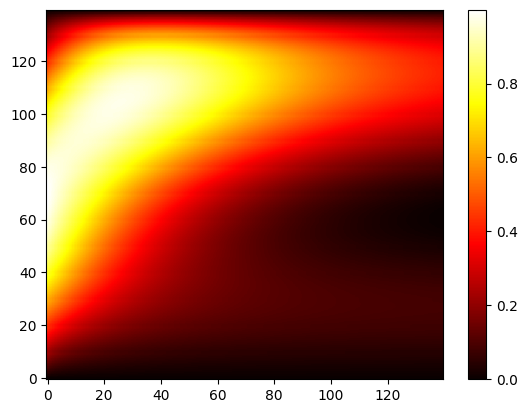

In [65]:
def problem_M(x, Nj, dNj, Nk, dNk):
    return Nj * Nk

def problem_B_CD(x, Nj, dNj, Nk, dNk):
    return -mu*Nj * dNk - eps*dNj * dNk

def problem_L_CD(x, Nj, dNj, f, a_fourier):
    return  f(x, a_fourier) * Nj

xmin = 0; xmax = 1; N = 15
x = np.linspace(xmin,xmax, N)
mu =  1
eps = 0.1
p = 2
k = 1
neval = 4

def u_0(x):
    return jnp.sin(np.pi * x)

a_fourier = np.random.choice(np.linspace(-1,1, 100), 4)

def f(x, a_fourier):
    basis_fourier = jnp.array([jnp.sin(l * jnp.pi * x) for l in range(1,5)])
    return jnp.dot(a_fourier, basis_fourier)
    
def solve_conv_diff(p,k, x, f, a_fourier, neval = 10):
    mesh = create_mesh(x)
    space = create_fe_space(deg = p,reg = k, mesh = mesh)
    param_map = create_param_map(mesh)
    ref_data = create_ref_data(neval = neval, deg = p, integrate = True)

    N_time = mesh['m']*neval
    dt = 1/N_time

    bc = [0,0]
    
    u_init = projection(mesh, space, ref_data, param_map, u_0)

    M,_ = assemble_fe_problem(mesh, space, ref_data, param_map, problem_M, problem_L_CD, f,a_fourier,  bc)
    S, F = assemble_fe_problem(mesh,space, ref_data, param_map, problem_B_CD, problem_L_CD, f, a_fourier,bc)
    
    M = csc_matrix(1/dt * M)
    S = csc_matrix(S)
    U = np.zeros((N_time, space['n']))
    
    U[0] = u_init
    U[:,0] = 0
    U[:,-1] = 0
    t = np.zeros(N_time)
    U_eval = []
    dU_dx_eval = []
    
    x_eval, u_eval, du_dx_eval = evaluate_solution(p, k, neval, u_init, x)
    U_eval.append(u_eval)
    dU_dx_eval.append(du_dx_eval) 
    A = M - S
    for i in range(1, N_time):
        t[i] = t[i-1] + dt 
        rhs =  M.dot(U[i-1][1:-1]) + F 
        u_inner = spsolve(A, rhs)
        U[i, 1:-1] = u_inner
        x_eval, u_eval, du_dx_eval = evaluate_solution(p, k, neval, U[i], x)
        U_eval.append(u_eval) 
        dU_dx_eval.append(du_dx_eval) 
    return U_eval, dU_dx_eval, x_eval, t 

U_eval, dU_dx, x_eval, t_eval  = solve_conv_diff(p,k,x,f, a_fourier)


plt.figure()
plt.imshow(np.array(U_eval[:]).T, aspect='auto', origin='lower', cmap='hot')
plt.colorbar()

print(np.shape(U_eval))

### Baseline FeedForward Neural Network 


Initialize baseline FeedForward neural netowork for mimicking the finite element solver. For the implementation of PINN's and neural operatos we will build upon the baseline nn. 

In [45]:
class FeedForwardNN:
    def __init__(self, layer_sizes, key, activation_fn = jax.nn.relu):
        self.layer_sizes = layer_sizes
        self.key = key
        self.activation_fn = activation_fn 
        self.params = self.initialize_params(layer_sizes, key)
    def initialize_params(self, layer_sizes, key):
        params = []
        keys = random.split(key, len(layer_sizes) -1)
        for i in range(len(layer_sizes) -1):
            W_key, b_key = random.split(keys[i])
            W = random.normal(W_key, (layer_sizes[i], layer_sizes[i+1])) * jnp.sqrt(2.0/layer_sizes[i]) #weights
            b = jnp.zeros(layer_sizes[i+1]) #biases
            params.append((W,b))
        return params
    
    def forward(self, params, x):
        for W,b in params[:-1]:
            x = jnp.dot(x,W) + b 
            x = self.activation_fn(x)
        
        W,b = params[-1]
        x = jnp.dot(x,W) + b
        return x 

    def predict(self, x):
        return self.forward(self.params, x)


In [46]:
import optax 
from tqdm import trange, tqdm


In [47]:
from jax import jit,vmap  

### DeepONet architecture

In [48]:
class DeepONet:
    def __init__(self, branch_layer_sizes, trunk_layer_sizes, key, activation_fn=jax.nn.tanh):
        # Initialize branch and trunk networks
        branch_key, trunk_key = random.split(key)
        self.branch_net = FeedForwardNN(branch_layer_sizes, branch_key, activation_fn)
        self.trunk_net = FeedForwardNN(trunk_layer_sizes, trunk_key, activation_fn)

    def params(self):
        return [self.branch_net.params, self.trunk_net.params]
    def set_params(self, new_params):
        self.branch_net.params = new_params[0]
        self.trunk_net.params = new_params[1]
    @partial(jit, static_argnums=(0,))
    def forward(self, params, branch_input, trunk_input):
        # Forward pass through branch and trunk networks
        branch_output = self.branch_net.forward(params[0], branch_input)
        trunk_output = self.trunk_net.forward(params[1], trunk_input)
        # Combine outputs using inner product
        return jnp.dot(branch_output, trunk_output.T)
    
    @partial(jit, static_argnums=(0,))
    def forward_squeeze(self, params, branch_input, trunk_input):
        return self.forward(params, branch_input, trunk_input).squeeze()

    def predict(self, branch_input, trunk_input):
        # Predict output for given inputs
        return vmap(self.forward, in_axes=(None, 0, 0))(self.params(), branch_input, trunk_input)

### Generate train and validation dataset 

In [71]:

def generate_data(p = 2, k = 1, n_input_sensors = 32, N_elements = 10, neval = 10, N_samples = 100, P = 100, M = 1, seed = 42):
    np.random.seed(seed)
    x_sensors = np.linspace(0,1, n_input_sensors)
    x = np.linspace(0,1, N_elements)

    forcing_terms = []
    solutions = []
    X_evaluations = []
    T_evaluations = []
    a_coef = []
    jit
    def f(x, a_fourier):
        basis_fourier = jnp.array([jnp.sin(ell * jnp.pi * x) for ell in range(1,5)])
        return jnp.dot(a_fourier, basis_fourier)

    a_coefs = np.random.choice(np.linspace(-M,M, 100), (N_samples, 4))
    for iter in range(N_samples):
        print(f"\r{iter}", end='', flush=True)
        a_fourier = a_coefs[iter]
        U_eval, dU_dx_eval, X_eval, t = solve_conv_diff(p, k, x, f, a_fourier, neval)
        forcing_terms.append(f(x_sensors, a_fourier))
        solutions.append(U_eval)
        X_evaluations.append(X_eval)
        T_evaluations.append(t)


    data = {'f':[],'x':[],'t':[],'y':[],'a_coef':[]}
    for k in range(N_samples):
        print(f"\r{k}", end='', flush=True)
        for j in range(P):
            data['f'].append(forcing_terms[k])
            idx_t = np.random.randint(0, len(T_evaluations[k]))
            idx_x = np.random.randint(0, len(X_evaluations[k]))
            data['y'].append(solutions[k][idx_t][idx_x])
            data['t'].append(T_evaluations[k][idx_t])
            data['x'].append(X_evaluations[k][idx_x])    
            data['a_coef'].append(a_coefs[k])
    return data 



In [51]:
train_data = generate_data(n_input_sensors=32, seed = 42)

validation_data = generate_data(n_input_sensors=32, seed = 43)

test_data = generate_data(n_input_sensors=32, seed = 44)

0

99

In [52]:
from pathlib import Path
import pickle
import os

def get_data_dir():
    """Returns the correct data directory path whether in script or notebook"""
    try:
        # Works in regular Python files
        return Path(__file__).parent.parent / "data"
    except NameError:
        # Fallback for notebooks - assumes you're running from code/ directory
        return Path.cwd().parent / "data"

DATA_DIR = get_data_dir()

def save_to_data(data, filename="train_data.pkl"):
    """Save data to the root-level data directory"""
    DATA_DIR.mkdir(exist_ok=True)  # Creates if doesn't exist
    filepath = DATA_DIR / filename
    with open(filepath, "wb") as f:
        pickle.dump(data, f)
    print(f"Data saved to: {filepath}")
    return filepath

def load_from_data(filename="train_data.pkl"):
    """Load data from the root-level data directory"""
    filepath = DATA_DIR / filename
    with open(filepath, "rb") as f:
        return pickle.load(f)

In [53]:
save_to_data(train_data, "train_data_batch_size.pkl")
save_to_data(validation_data, "validation_data_batch_size.pkl")
save_to_data(test_data, "test_data_batch_size.pkl")

Data saved to: /Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/train_data_batch_size.pkl
Data saved to: /Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/validation_data_batch_size.pkl
Data saved to: /Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/test_data_batch_size.pkl


PosixPath('/Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/test_data_batch_size.pkl')

In [54]:

import optax 
from tqdm import trange, tqdm



In [55]:
def train_DON(nn, train_data, validation_data, mse = True,  batch_size = 1, max_iterations = 10000):
    f_train = jnp.array(train_data['f'])
    t_train = jnp.array(train_data['t'])
    x_train = jnp.array(train_data['x'])
    y_train = jnp.array(train_data['y'])
    a_train = jnp.array(train_data['a_coef'])
    train_losses = []

    validation_losses = []
    f_validation = jnp.array(validation_data['f'])
    t_validation = jnp.array(validation_data['t'])
    x_validation = jnp.array(validation_data['x'])
    y_validation = jnp.array(validation_data['y'])
    a_validation = jnp.array(validation_data['a_coef'])
    
    learning_rate_schedule = optax.piecewise_constant_schedule(
        init_value=0.01,
        boundaries_and_scales={2000: 0.5, 4000: 0.5, 6000 :0.1, 8000:0.1}
    )

    optimizer = optax.adam(learning_rate=learning_rate_schedule)
    opt_state = optimizer.init(nn.params())
    
    pbar = trange(max_iterations, desc="Training", leave=True)

    jit
    def u_nn(params, f_sample, x, t): 
        return nn.forward(params, f_sample, jnp.stack([x, t], axis=-1))

    u_nn_t = jax.grad(u_nn, argnums= 3)
    u_nn_x = jax.grad(u_nn, argnums= 2)
    u_nn_xx = jax.grad(u_nn_x, argnums= 2)

    jit 
    def residual(params, f_sample, x, t, a):
        basis_fourier = jnp.array([jnp.sin(ell * jnp.pi * x) for ell in range(1,5)])
        return u_nn_t(params, f_sample, x, t) + mu * u_nn_x(params, f_sample, x, t) - eps * u_nn_xx(params, f_sample, x, t) -  jnp.dot(a, basis_fourier)

    residual_batch = jit(vmap(residual, in_axes=(None, 0, 0, 0, 0)))

    jit
    def initial_loss(params, f, x):
        return u_nn(params, f, x,0) - u_0(x)

    jit
    def boundary0_loss(params, f, t):
        return u_nn(params, f, 0,t) - 0 

    jit
    def boundary1_loss(params, f, t):
        return u_nn(params, f, 1,t) - 0 

    initial_loss_batch = jit(vmap(initial_loss, in_axes=(None, 0, 0)))

    boundary0_loss_batch = jit(vmap(boundary0_loss, in_axes=(None, 0, 0)))
    boundary1_loss_batch = jit(vmap(boundary1_loss, in_axes=(None, 0, 0)))

    jit
    def squared_error(params, f_sample, x, t, y, a):
        return (u_nn(params, f_sample, x, t) - y)**2

    squared_error_batch = jit(vmap(squared_error, in_axes =(None, 0, 0, 0, 0, 0))) 

    jit 
    def physics_loss(params, f_sample, x, t, y, a):
        residual = jnp.mean(residual_batch(params, f_sample, x, t, a)**2)
        initial = jnp.mean(initial_loss_batch(params, f_sample, x)**2)
        boundary_0 = jnp.mean(boundary0_loss_batch(params, f_sample, t)**2)
        boundary_1 = jnp.mean(boundary1_loss_batch(params, f_sample, t)**2)
        return residual + 10*(initial + boundary_0 + boundary_1)

    jit 
    def data_loss(params, f_sample, x, t, y, a):
        return jnp.mean(squared_error_batch(params, f_sample, x, t, y,a))

    jit
    def combined_loss(params, f_sample, x, t, y, a):
        return data_loss(params, f_sample, x, t, y, a) + physics_loss(params, f_sample, x, t, y, a) 
    
    jit 
    def train_step(params, opt_state, f_sample, x, t, y, a, loss_function, optimizer):
        loss, grads = jax.value_and_grad(loss_function)(params, f_sample, x, t, y, a)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss
    if (mse):
        loss_function = data_loss
    else:
        loss_function = combined_loss 
    for epoch in pbar:
        idicies = np.random.choice(len(f_train),int(len(f_train)*batch_size), replace = False) #extract random batches from train data 
        don_params, opt_state, current_train_loss = train_step(nn.params(), opt_state, f_train[idicies], x_train[idicies], t_train[idicies], y_train[idicies], a_train[idicies], loss_function, optimizer)
        current_val_loss = loss_function(nn.params(), f_validation, x_validation, t_validation, y_validation, a_validation)
        nn.branch_net.params = don_params[0] 
        nn.trunk_net.params = don_params[1]
        train_losses.append(current_train_loss)
        validation_losses.append(current_val_loss)
        if epoch % 10 == 0:
            pbar.set_postfix({'train_loss': current_train_loss, 'validation_loss': current_val_loss})

    return nn.params(), train_losses, validation_losses

In [56]:
params_batch_size = {}
train_loss_batch_size = {}
validation_loss_batch_size = {}

In [57]:
key = random.PRNGKey(0)
n_input_sensors = 32
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]
nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)
max_iter = 10000
params_batch_size_02, train_losses_batch_size_02, validation_losses_batch_size_02 = train_DON(nn, train_data, validation_data, mse = False, batch_size = 0.2, max_iterations= max_iter)
params_batch_size['0.2'] = params_batch_size_02
train_loss_batch_size['0.2'] = train_losses_batch_size_02
validation_loss_batch_size['0.2'] = validation_losses_batch_size_02

key = random.PRNGKey(0)
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]
nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)

params_batch_size_05, train_losses_batch_size_05, validation_losses_batch_size_05 = train_DON(nn, train_data, validation_data, mse=False, batch_size = 0.5, max_iterations= max_iter)
params_batch_size['0.5'] = params_batch_size_05
train_loss_batch_size['0.5'] = train_losses_batch_size_05
validation_loss_batch_size['0.5'] = validation_losses_batch_size_05

key = random.PRNGKey(0)
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]
nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)


params_batch_size_1, train_losses_batch_size_1, validation_losses_batch_size_1 = train_DON(nn, train_data, validation_data, mse=False, batch_size = 1.0, max_iterations= max_iter)
params_batch_size['1'] = params_batch_size_1
train_loss_batch_size['1'] = train_losses_batch_size_1
validation_loss_batch_size['1'] = validation_losses_batch_size_1
    

Training: 100%|██████████| 10000/10000 [4:04:45<00:00,  1.47s/it, train_loss=0.032779988, validation_loss=0.049782436]    


In [58]:
import pickle

save_to_data(params_batch_size, "params_batch_size.pkl")
save_to_data(train_loss_batch_size, "train_loss_batch_size.pkl")
save_to_data(validation_loss_batch_size, "validation_loss_batch_size.pkl")

Data saved to: /Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/params_batch_size.pkl
Data saved to: /Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/train_loss_batch_size.pkl
Data saved to: /Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/validation_loss_batch_size.pkl


PosixPath('/Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/validation_loss_batch_size.pkl')

In [59]:

params_extracted = load_from_data("params_batch_size.pkl")

train_loss_extracted = load_from_data("train_loss_batch_size.pkl")

validation_loss_extracted = load_from_data("validation_loss_batch_size.pkl")

dict_keys(['0.2', '0.5', '1'])


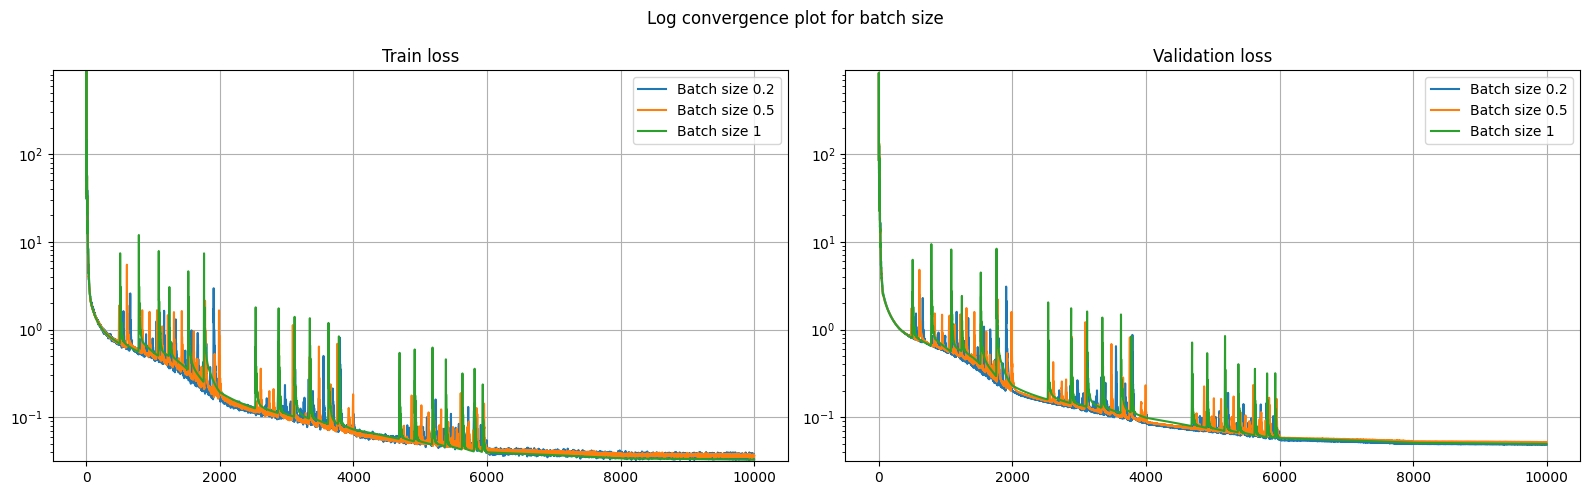

In [60]:
fig, axes = plt.subplots(1,2, figsize = (16,5))
print(train_loss_extracted.keys())
max_ylim = 0
min_ylim = 10000
for key in train_loss_batch_size.keys():
    axes[0].plot(train_loss_extracted[key], label = 'Batch size ' +  key)
    axes[1].plot(validation_loss_extracted[key], label = 'Batch size ' + key)
    max_ylim = np.max([max_ylim, np.max(train_loss_extracted[key]), np.max(validation_loss_extracted[key])])
    min_ylim = np.min([min_ylim, np.min(train_loss_extracted[key]), np.min(validation_loss_extracted[key])])
axes[0].legend()
axes[1].legend()
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_ylim([min_ylim,max_ylim])
axes[1].set_ylim([min_ylim,max_ylim])
axes[0].set_title(f'Train loss')
axes[1].set_title(f'Validation loss')
fig.suptitle(f'Log convergence plot for batch size')
fig.tight_layout()
fig.savefig(f'log_convergence_batch_size.png')


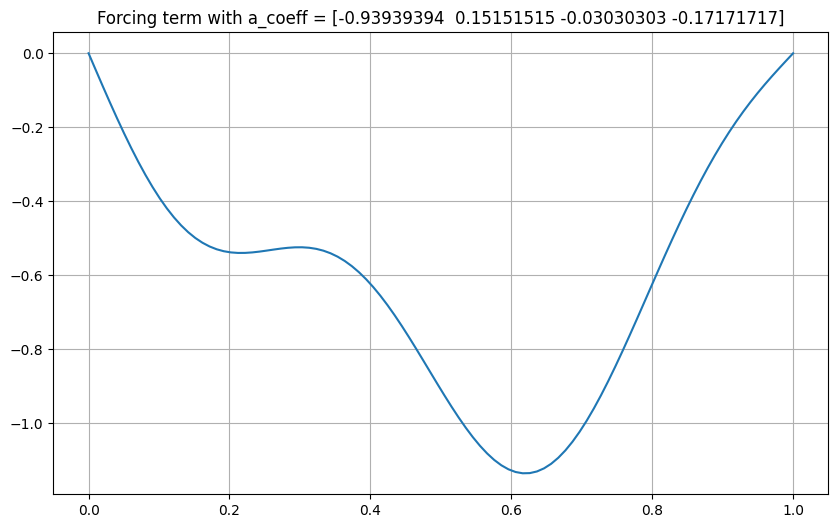

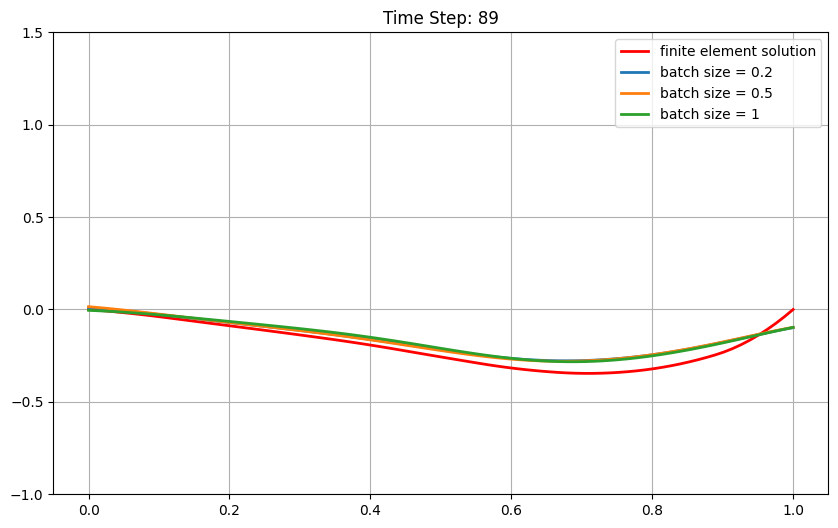

In [67]:

key = random.PRNGKey(0)
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]

nn_02 = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)

nn_02.set_params(params_extracted['0.2'])

nn_05 = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)

nn_05.set_params(params_extracted['0.5'])

nn_1 = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)

nn_1.set_params(params_extracted['1'])

from matplotlib.colors import LogNorm

a_fourier = np.random.choice(np.linspace(-1.0,1.0, 100), 4)
def f(x, a_fourier):
    basis_fourier = jnp.array([jnp.sin(ell * jnp.pi * x) for ell in range(1,5)])
    return jnp.dot(a_fourier, basis_fourier)

f_test = f(np.linspace(0,1, n_input_sensors), a_fourier)

x = np.linspace(0,1,10)
u_eval, dU_dx_eval, x_eval, t_eval = solve_conv_diff(2,1, x, f, a_fourier, neval = 10)

xx_test, tt_test = np.meshgrid(x_eval,t_eval)


U_nn_02 = nn_02.forward(nn_02.params(), f_test, jnp.stack([xx_test.flatten(), tt_test.flatten()], axis=-1))
U_nn_05 = nn_05.forward(nn_05.params(), f_test, jnp.stack([xx_test.flatten(), tt_test.flatten()], axis=-1))
U_nn_1 = nn_1.forward(nn_1.params(), f_test, jnp.stack([xx_test.flatten(), tt_test.flatten()], axis=-1))

plt.figure(figsize = (10,6))
plt.title(f'Forcing term with a_coeff = {a_fourier}')
plt.plot(np.linspace(0,1,100), f(np.linspace(0,1,100),a_fourier))
plt.grid()
# plt.figure()
# plt.imshow(np.array(u_eval).reshape(np.shape(xx_test)))
# plt.colorbar()

# plt.figure()
# plt.imshow(U_nn.reshape(np.shape(xx_test)))
# plt.colorbar()

# plt.figure()
# plt.imshow(np.abs(np.array(u_eval).reshape(np.shape(xx_test)) - U_nn.reshape(np.shape(xx_test))))#, norm = LogNorm())
# plt.colorbar()

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

U1 = np.array(u_eval).reshape(np.shape(xx_test))
U2 = np.array(U_nn_02).reshape(np.shape(xx_test))
U3 = np.array(U_nn_05).reshape(np.shape(xx_test))
U4 = np.array(U_nn_1).reshape(np.shape(xx_test))


fig, ax = plt.subplots(figsize=(10, 6))
line1, = ax.plot(x_eval, U1[0,:], 'r-', linewidth=2, label = f'finite element solution')
line2, = ax.plot(x_eval, U2[ 0,:], linewidth=2, label = f'batch size = 0.2')
line3, = ax.plot(x_eval, U3[ 0,:], linewidth=2, label = f'batch size = 0.5')
line4, = ax.plot(x_eval, U4[ 0,:], linewidth=2, label = f'batch size = 1')
time_steps = np.shape(U1)[1]
ax.set_ylim(-1, 1.5)

def update(frame):
    line1.set_ydata(U1[frame, :])
    line2.set_ydata(U2[frame, :])
    line3.set_ydata(U3[frame, :])
    line4.set_ydata(U4[frame, :])
    
    ax.set_title(f'Time Step: {frame}')
    return line1,line2

ani = FuncAnimation(
    fig, 
    update, 
    frames=time_steps,
    interval=50,  # Delay between frames in ms
    blit=True
)
ax.grid(True)
ax.legend()
HTML(ani.to_jshtml())


In [76]:
test_data_batch_size = load_from_data("test_data_batch_size.pkl")

key = random.PRNGKey(0)
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]

nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)

u_nn = jax.jit(lambda params, f, x, t : nn.forward(params, f, jnp.stack([x, t], axis=-1)))

for key in params_batch_size.keys():
    jit
    def squared_error(params, f_sample, x, t, y, a):
        return (u_nn(params, f_sample, x, t) - y)**2

    squared_error_batch = jit(vmap(squared_error, in_axes =(None, 0, 0, 0, 0, 0))) 
    jit 
    def data_loss(params, f_sample, x, t, y, a):
        return jnp.mean(squared_error_batch(params, f_sample, x, t, y,a))

    print(key, f'{data_loss(params_batch_size[key], jnp.array(test_data_batch_size['f']), jnp.array(test_data_batch_size['x']), jnp.array(test_data_batch_size['t']),jnp.array(test_data_batch_size['y']), jnp.array(test_data_batch_size['a_coef'])):.2e}')




0.2 7.33e-04
0.5 8.41e-04
1 1.07e-03


In [77]:

test_data_15 = generate_data(M = 1.5)
save_to_data(test_data_15, "test_data_15_batch_size.pkl")
key = random.PRNGKey(0)
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]

nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)

u_nn = jax.jit(lambda params, f, x, t : nn.forward(params, f, jnp.stack([x, t], axis=-1)))

for key in params_batch_size.keys():
    jit
    def squared_error(params, f_sample, x, t, y, a):
        return (u_nn(params, f_sample, x, t) - y)**2

    squared_error_batch = jit(vmap(squared_error, in_axes =(None, 0, 0, 0, 0, 0))) 
    jit 
    def data_loss(params, f_sample, x, t, y, a):
        return jnp.mean(squared_error_batch(params, f_sample, x, t, y,a))

    print(key, f'{data_loss(params_batch_size[key], jnp.array(test_data_15['f']), jnp.array(test_data_15['x']), jnp.array(test_data_15['t']),jnp.array(test_data_15['y']), jnp.array(test_data_15['a_coef'])):.2e}')



0

99Data saved to: /Users/markussandnes/Desktop/TU DELFT/Special topics in computational science and engineering /group-8/data/test_data_15_batch_size.pkl
0.2 5.21e-03
0.5 5.02e-03
1 5.19e-03


In [ ]:
key = random.PRNGKey(0)
n_input_sensors = 32
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]

nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)
x_sensors = np.linspace(0,1, n_input_sensors)
forcing_terms_train = []
for a in train_data['a_coef']:
    a_fourier = np.copy(a)
    forcing_terms_train.append(f(x_sensors, a_fourier))

train_data['f'] = forcing_terms_train

forcing_terms_validation = []
for a in validation_data['a_coef']:
    a_fourier = np.copy(a)
    forcing_terms_validation.append(f(x_sensors, a_fourier))

validation_data['f'] = forcing_terms_validation
params_32, train_loss_32, validation_loss_32 = train_DON(nn, train_data, validation_data, mse = False, batch_size=0.1, max_iterations = 10000)

Training: 100%|██████████| 10000/10000 [19:18<00:00,  8.63it/s, train_loss=0.03481901, validation_loss=0.05645083] 


In [ ]:
u_nn = jax.jit(lambda params, f, x, t : nn.forward(params, f, jnp.stack([x, t], axis=-1)))
u_nn_t = jax.grad(u_nn, argnums= 3)
u_nn_x = jax.grad(u_nn, argnums= 2)
u_nn_xx = jax.grad(u_nn_x, argnums= 2)
jit
def squared_error(params, f_sample, x, t, y, a):
    return (u_nn(params, f_sample, x, t) - y)**2

squared_error_batch = jit(vmap(squared_error, in_axes =(None, 0, 0, 0, 0, 0))) 
jit 
def data_loss(params, f_sample, x, t, y, a):
    return jnp.mean(squared_error_batch(params, f_sample, x, t, y,a))


x_sensors = np.linspace(0,1, n_input_sensors)
forcing_terms_test = []
for a in test_data['a_coef']:
    a_fourier = np.copy(a)
    forcing_terms_test.append(f(x_sensors, a_fourier))

test_data['f'] = forcing_terms_test
nn.set_params(params_32)

print(n_input_sensors, data_loss(nn.params(), jnp.array(test_data['f']), jnp.array(test_data['x']), jnp.array(test_data['t']),jnp.array(test_data['y']), jnp.array(test_data['a_coef'])))


32 0.00073603104


In [ ]:
key = random.PRNGKey(0)
n_input_sensors = 2
branch_layer_sizes = [n_input_sensors,64, 64, 10]
trunk_layer_sizes = [2, 64, 64, 10]

nn = DeepONet(branch_layer_sizes, trunk_layer_sizes, key)
x_sensors = np.linspace(0,1, n_input_sensors)
forcing_terms_train = []
for a in train_data['a_coef']:
    a_fourier = np.copy(a)
    forcing_terms_train.append(f(x_sensors, a_fourier))

train_data['f'] = forcing_terms_train

forcing_terms_validation = []
for a in validation_data['a_coef']:
    a_fourier = np.copy(a)
    forcing_terms_validation.append(f(x_sensors, a_fourier))

validation_data['f'] = forcing_terms_validation

params_2, train_loss_2, validation_loss_2 = train_DON(nn, train_data, validation_data, mse = False, batch_size=0.1, max_iterations = 10000)

Training: 100%|██████████| 10000/10000 [30:01<00:00,  5.55it/s, train_loss=0.6327632, validation_loss=0.68350047]  


In [73]:
u_nn = jax.jit(lambda params, f, x, t : nn.forward(params, f, jnp.stack([x, t], axis=-1)))
u_nn_t = jax.grad(u_nn, argnums= 3)
u_nn_x = jax.grad(u_nn, argnums= 2)
u_nn_xx = jax.grad(u_nn_x, argnums= 2)
jit
def squared_error(params, f_sample, x, t, y, a):
    return (u_nn(params, f_sample, x, t) - y)**2

squared_error_batch = jit(vmap(squared_error, in_axes =(None, 0, 0, 0, 0, 0))) 
jit 
def data_loss(params, f_sample, x, t, y, a):
    return jnp.mean(squared_error_batch(params, f_sample, x, t, y,a))

x_sensors = np.linspace(0,1, n_input_sensors)
forcing_terms_test = []
for a in test_data['a_coef']:
    a_fourier = np.copy(a)
    forcing_terms_test.append(f(x_sensors, a_fourier))

test_data['f'] = forcing_terms_test
nn.set_params(params_2)
print(n_input_sensors, data_loss(nn.params(), jnp.array(test_data['f']), jnp.array(test_data['x']), jnp.array(test_data['t']),jnp.array(test_data['y']), jnp.array(test_data['a_coef'])))


TypeError: dot_general requires contracting dimensions to have the same shape, got (32,) and (2,).

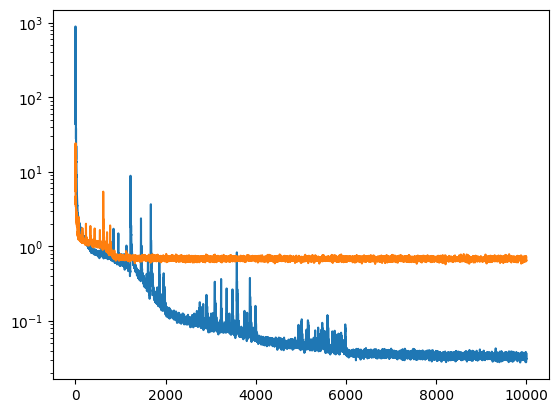

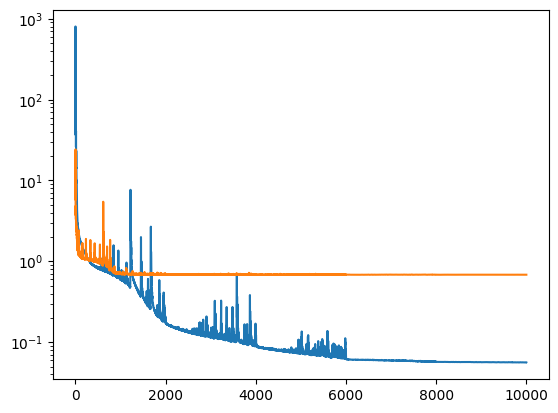

In [ ]:
plt.plot(train_loss_32)
plt.plot(train_loss_2)
plt.yscale('log')
plt.figure()
plt.plot(validation_loss_32)
plt.plot(validation_loss_2)
plt.yscale('log')

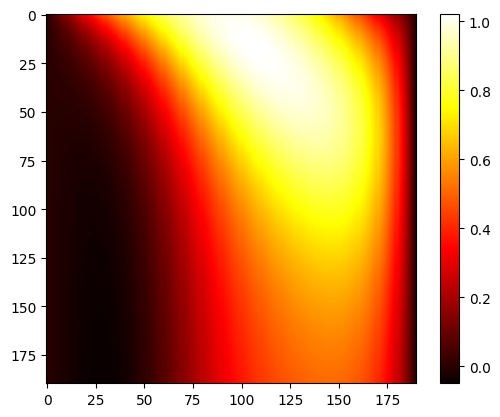

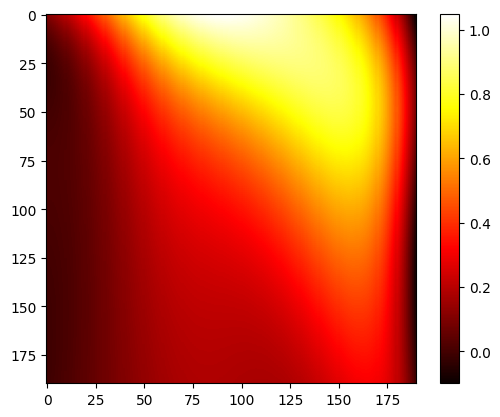

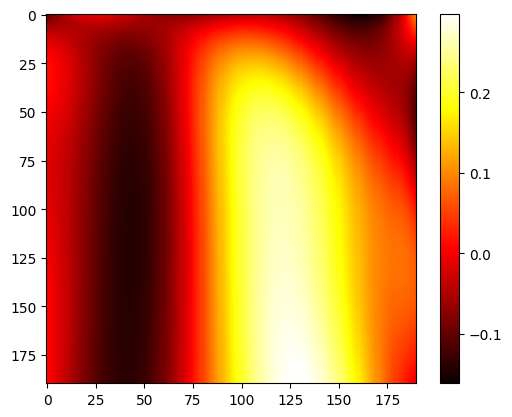

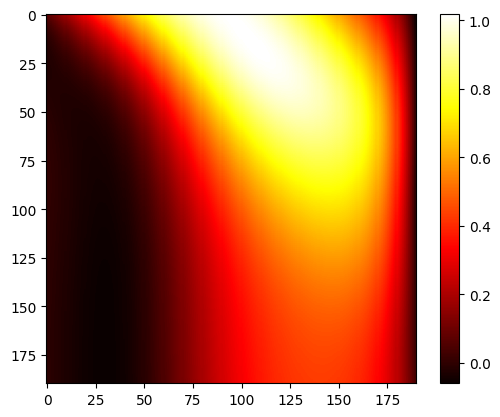

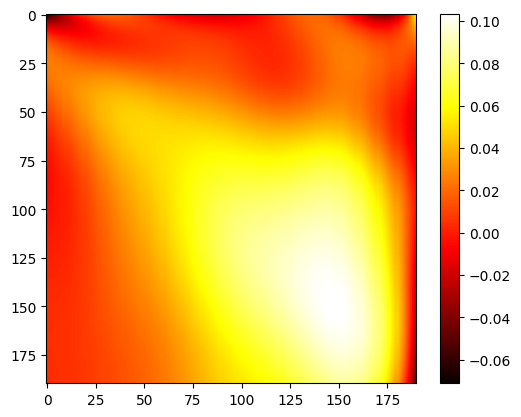

In [ ]:
a_fourier= np.random.choice(np.linspace(-1.0,1.0, 100), 4)
def f(x):
    basis_fourier = jnp.array([jnp.sin(ell * jnp.pi * x) for ell in range(1,5)])
    return jnp.dot(a_fourier, basis_fourier)

f_test = f(np.linspace(0,1, n_input_sensors))

x = np.linspace(0,1,20)
u_eval, dU_dx_eval, x_eval, t_eval = solve_conv_diff(2,1, x, neval = 10)

xx_test, tt_test = np.meshgrid(x_eval,t_eval)


U_nn = nn.forward(nn.params(), f_test, jnp.stack([xx_test.flatten(), tt_test.flatten()], axis=-1))
U_nn_02 = nn.forward(params_batch_size_02, f_test, jnp.stack([xx_test.flatten(), tt_test.flatten()], axis=-1))


plt.figure()
plt.imshow(np.array(u_eval).reshape(np.shape(xx_test)), cmap = 'hot')
plt.colorbar()

plt.figure()
plt.imshow(U_nn.reshape(np.shape(tt_test)), cmap = 'hot')
plt.colorbar()

plt.figure()
plt.imshow(np.array(u_eval).reshape(np.shape(xx_test)) - U_nn.reshape(np.shape(tt_test)), cmap = 'hot')
plt.colorbar()

plt.figure()
plt.imshow(U_nn_02.reshape(np.shape(tt_test)), cmap = 'hot')
plt.colorbar()

plt.figure()
plt.imshow(np.array(u_eval).reshape(np.shape(xx_test)) - U_nn_02.reshape(np.shape(tt_test)), cmap = 'hot')
plt.colorbar()